# Préliminaires : Génération "aléatoire" de programme linéaire

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

plt.rcParams['figure.dpi'] = 100

On commence par créér un générateur plus ou moins aléatoire de programme linéaire, qui soient satisfiables, et dont on connait un point faisable.

Pour cela on part du polytope de base qui est un carré centré en 0, i.e. la boule induite par la norme 1.

On prend ensuite un point aléatoire $x =\begin{bmatrix}
           x_1\\
           x_2\\
         \end{bmatrix}$ 
du carré, qui va nous servir de point faisable, et de point de départ pour nos algorithmes d'optimisation : on veut donc que ce point reste dans le polytope.

On génère ensuite un certain nombre de droite. Pour cela, pour chaque droite on génère un vecteur $a=\begin{bmatrix}
           a_1\\
           a_2\\
         \end{bmatrix}$ ainsi qu'un biais $b$, puis il y a 3 choix possible :
* $a^Tx-b< 0$ : on ajoute la contrainte $a^Tx\le b$ au problème
* $a^Tx-b> 0$ : on ajoute la contrainte $-a^Tx\le -b$ au problème
* $a^Tx-b= 0$ : on n'ajoute pas la contrainte car on veut que $x$ soit strictement faisable
Cela donne l'algorithme suivant :

In [2]:
# n le nombre de contraintes qu'on veut ajouter
# eps est une erreur pour la comparaison de floattant
def generateLP(n=5,eps=1e-5):
    A = [[0.,1.],[0.,-1.],[1.,0.],[-1.,0.]]
    B = [1.,1.,1.,1.]
    x = np.random.uniform(-1.,1.,(2))
    remaining = n
    while remaining:
        a = np.random.randn(2)
        b = np.random.randn(1)
        if (np.dot(a,x)-b<eps):
            A.append(a.tolist())
            B.append(b.item())
            remaining -= 1
        if (np.dot(a,x)-b>eps):
            A.append((-a).tolist())
            B.append((-b).item())
            remaining -= 1
    direction = np.random.randn(2)
    return np.array(A),np.array(B),x,direction

In [3]:
def is_inside(A,b,x):
    return np.all((np.dot(A,x)-b)<=0)

def plotLP(A,b,c=None,func=None):
    nb_points = 200
    xlist = np.linspace(-1., 1., nb_points)
    ylist = np.linspace(-1., 1., nb_points)
    X, Y = np.meshgrid(xlist, ylist)
    i,j = X.shape
    Z = np.zeros((i,j))
    xmin,xmax,ymin,ymax = 1.,-1.,1.,-1.
    for k in range(i):
        for l in range(j):
            if (is_inside(A,b,np.array([X[k,l],Y[k,l]]))):
                xmin = min(xmin, X[k,l])
                ymin = min(ymin, Y[k,l])
                xmax = max(xmax, X[k,l])
                ymax = max(ymax, Y[k,l])
                if func is None:
                    Z[k,l] = np.dot(c,np.array([X[k,l],Y[k,l]]))
                else:
                    Z[k,l] = func(np.array([X[k,l],Y[k,l]]))
            else:
                Z[k,l] = None
    
    margin_factor = 20
    xmin -= (xmax-xmin)/margin_factor
    xmax += (xmax-xmin)/margin_factor
    ymin -= (ymax-ymin)/margin_factor
    ymax += (ymax-ymin)/margin_factor
    
    plt.axis([xmin,xmax,ymin,ymax])
    cp = plt.contourf(X, Y, Z, 15)

On teste sur 6 programmes linéaire :

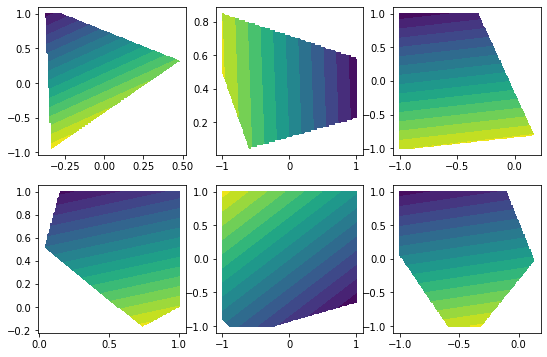

In [24]:
plt.figure(figsize=(9, 6))

for k in range(6):
    plt.subplot(2, 3, k+1)
    A,b,x,c = generateLP()
    plotLP(A,b,c)
plt.show()

Enfin on créé une fonction pour afficher la convergence de l'erreur de nos algorithmes :

In [5]:
def plotConvergence(points, optimal=None, f=None):
    X = np.arange(len(points))
    if optimal is not None:
        points = points - optimal
    else:
        mapping = np.array([f(i) for i in points])
        opt_index = np.argmin(mapping)
        points = points - points[opt_index]
    Y = np.linalg.norm(points,axis=1)
    plt.yscale('log')
    plt.plot(X,Y)

# Exercice 5 - Méthode de Newton

L'objectif est de résoudre le problème de minimisation suivant :
$$
\text{min}_{x\in R^n} -\sum_{i=1}^m log(b_i-a_i^T x)
$$
$$
A \in R^{m\times n}, b\in R^{m}
$$
C'est un problème d'optimisation convexe sans contraintes donc on peut utiliser la méthode de Newton.

On pose $f(x)=-\sum_{i=1}^m log(b_i-a_i^T x)$. On a :
$$
\nabla f(x) = \sum_{i=1}^m \frac{a_i}{b_i-a_i^T x}
$$
$$
\nabla^2 f(x) = \sum_{i=1}^m \frac{a_i a^T_i}{(a_i^T x-b_i)^2}
$$

In [6]:
def f(A,b):
    def f(x):
        c = b-np.dot(A,x)
        if np.any(c<=0):
            return math.inf
        else:
            return -np.sum(np.log(c))
    return f

def fGrad(A,b):
    def f(x):
        factor = (b-np.dot(A,x)).reshape(-1,1)
        return np.sum((A/factor),axis=0)
    return f

def fHess(A,b):
    def f(x):
        factor = np.square(b-np.dot(A,x)).reshape(-1,1,1)
        return np.sum(np.einsum('ij,ik->ijk',A,A)/factor, axis=0)
    return f

In [7]:
# calcule le pas de Newton ainsi que l'incrément de Newton
# le paramètre 'history' permet de garder la trace des étapes de l'algorithme
def NewtonMethod(f,grad,hess,x0,eps=1e-10,alpha=0.25,beta=0.5,record_history=False):
    x = x0
    history = []
    newton_decr_squared = 2*eps+1
    while True:
        history.append(x.tolist())
        G = grad(x)
        H = hess(x)
        newton_step = np.linalg.solve(H,-G)
        newton_decr_squared = -np.dot(newton_step,G)
        if newton_decr_squared/2 < eps:
            if record_history:
                return x, np.array(history)
            else:
                return x
        t = 1
        while (f(x+t*newton_step) > f(x) + alpha*t*np.dot(newton_step,G)):
            t *= beta
        x += t*newton_step    

On teste à présent notre algorithme sur différentes valeurs de $A$ et $b$ :

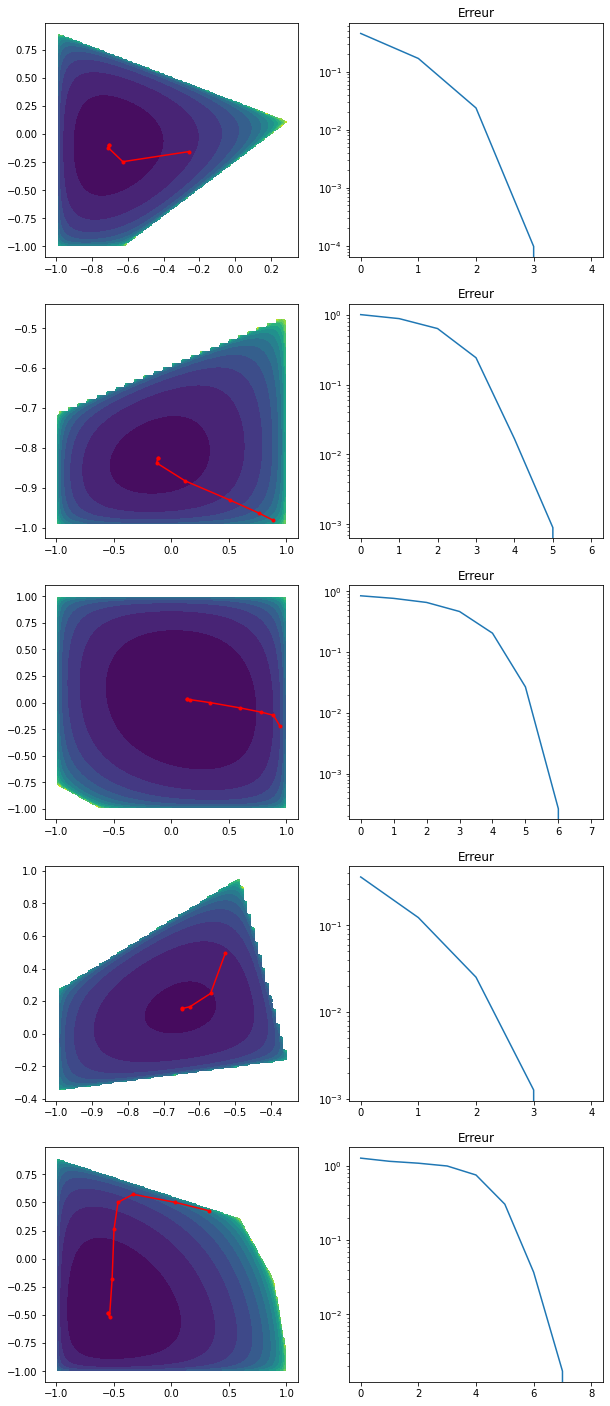

In [8]:
%matplotlib inline
nb = 5
plt.figure(figsize=(10, 5*nb))
for k in range(nb):
    plt.subplot(nb, 2, 2*k+1)
    A,b,x,_ = generateLP(3)
    _,history = NewtonMethod(f(A,b),fGrad(A,b),fHess(A,b),x,record_history=True)
    plotLP(A,b,func=f(A,b))
    plt.plot(history[:,0],history[:,1],marker='.',color='red')
    
    plt.subplot(nb, 2 , 2*k+2,title='Erreur')
    plotConvergence(history,f=f(A,b))
plt.show()

Proche de l'optimum la convergence est bien quadratique, bien que cela se voit plus ou moins bien en fonctions de la qualité des exemples générés. On peut utiliser un exemple où la convergence quadratique est bien visible :

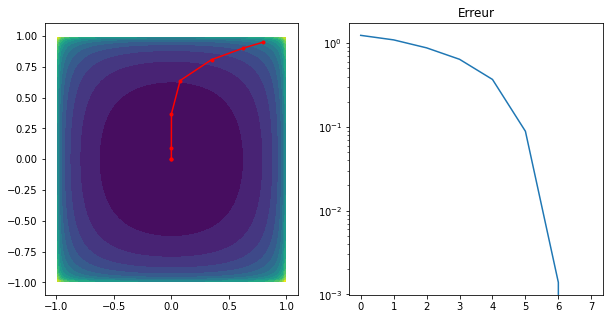

In [9]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
A,b,_,_ = generateLP(0)
_,history = NewtonMethod(f(A,b),fGrad(A,b),fHess(A,b),np.array([0.8,0.95]),record_history=True)
plotLP(A,b,func=f(A,b))
plt.plot(history[:,0],history[:,1],marker='.',color='red')

plt.subplot(1, 2 , 2,title='Erreur')
plotConvergence(history,f=f(A,b))

plt.show()

# Exercice 6 - Programmation linéaire

L'objectif est de résoudre le problème de programmation linéaire

$$
\text{minimize }\;\;\;\;\;\;\; c^T x
$$
$$
\text{subject to }\;\; Ax \le b
$$

À noter qu'on peut obtenir la solution du problème dual gratuitement en remarquant que pour un programme convexe

$$
\text{minimize }\;\;\;\;\;\;\; f_0(x)
$$
$$
\text{subject to }\;\; f_i(x) \le 0
$$

avec pour solution $x^*(t)$ à une étape $t$ de la barrière, le point $\lambda(t)$ définit par $\lambda_i(t)=\frac{1}{-tf_i(x^*(t))}$ est un point dual faisable. De plus on a que (cf cours) $g(\lambda(t)) = f_0(x^*(t)) - \frac{m}{t}$ donc $\lambda(t)$ va bien converger vers la solution du dual.

In [10]:
def LPBarrierMethod(A,b,c,x0,t0=0.1,mu=5,eps=1e-5,record_history=False):
    t = t0/mu
    x = x0
    history = []
    m = len(b)
    while m/t >= eps:
        t *= mu
        history.append(x.tolist())
        current_f = lambda x : t*np.dot(c,x) + f(A,b)(x)
        current_f_grad = lambda x : t*c + fGrad(A,b)(x)
        current_f_hess = fHess(A,b)
        x = NewtonMethod(current_f, current_f_grad, current_f_hess, x)
    dual = 1/(-t*(np.dot(A,x)-b))
    if record_history:
        history.append(x.tolist())
        return (x,dual), np.array(history)
    else:
        return (x,dual)

On teste à nouveau notre fonction sur différents programmes linéaires :

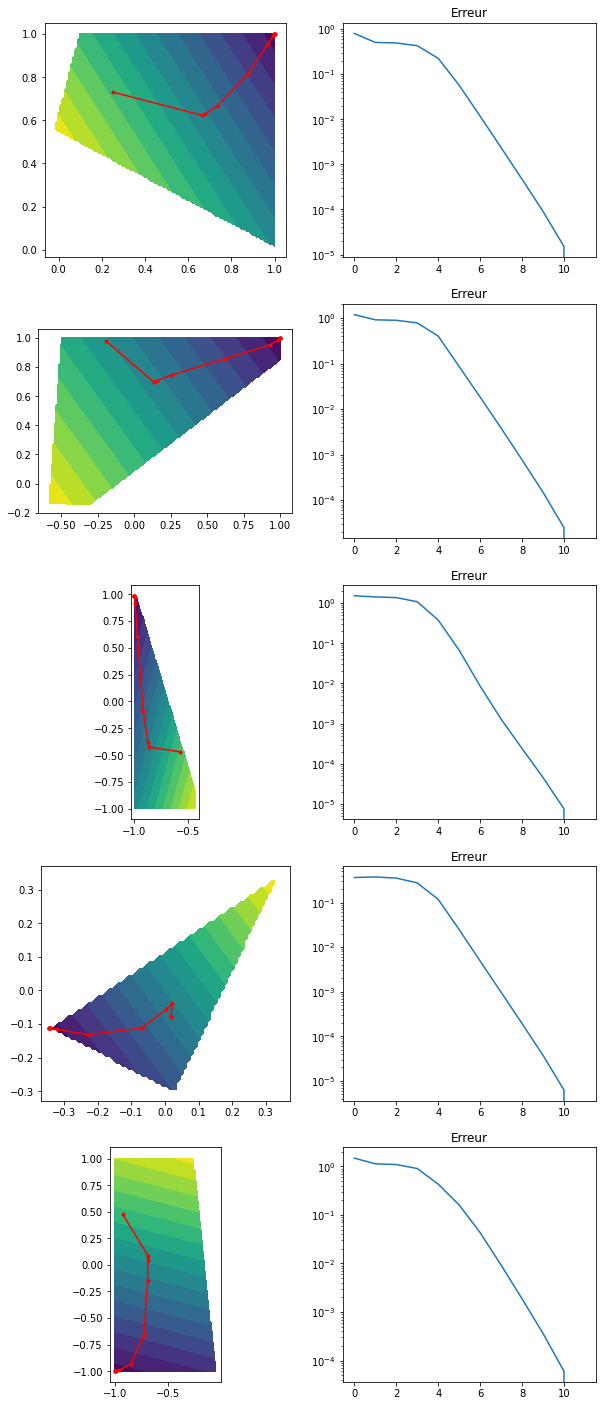

In [28]:
nb = 5
plt.figure(figsize=(10, 5*nb))
for k in range(nb):
    plt.subplot(nb, 2, 2*k+1)
    ax = plt.gca()
    ax.set_aspect('equal')
    A,b,x,c = generateLP(5)
    _,history = LPBarrierMethod(A,b,c,x,record_history=True)
    plotLP(A,b,c)
    plt.plot(history[:,0],history[:,1],marker='.',color='red')
    
    plt.subplot(nb, 2 , 2*k+2,title='Erreur')
    plotConvergence(history,f=lambda x:np.dot(c,x))
plt.show()

On remarque que des fois la première étape n'est pas optimale : c'est parce que j'ai utilisé une valeur initiale pour $t$ qui ne dépend pas du problème, et donc il arrive qu'intuitivement lors de la première étape, la barrière logarithmique soit encore "trop au centre" du polytope. On pourrait utiliser une valeur intiale pour $t$ qui dépend du problème, comme indiqué dans le livre de Vandenberghe et Boyd.

On code à présent une méthode pour trouver un point strictement faisable. Imaginons qu'on veuille trouver une solution faisable au problème :

$$
\text{minimize }\;\;\;\;\;\;\; c^T x
$$
$$
\text{subject to }\;\; Ax \le b
$$

On va utiliser le programme linéaire :

$$
\text{minimize }\;\;\;\;\;\;\;\;\;\;\;\;\;\;\; s
$$
$$
\text{subject to }\;\; Ax - b \le \boldsymbol{1}s
$$

On note $L$ le premier problème et $L_{\text{aux}}$ le second. On va montrer que $L$ est faisable ssi la valeur optimale de $L_{\text{aux}}$ est inférieure à 0.
* si $x$ est une solution faisable de $L$, alors clairement, $x,s=0$ est une solution faisable de $L_{aux}$
* si l'optimal de $L_{\text{aux}}$ est inférieur à 0, alors $s = 0$, et le reste de la solution nous donne une solution faisable de $x$

On note aussi que $L$ est strictement faisable ssi l'optimal de $L_{\text{aux}}$ est strictement négatif.
Sachant qu'on a facilement une solution strictement faisable pour $L_{\text{aux}}$ ($x = 0, s = 1+\text{min}(b)$), on peut optimiser sur le programme $L_{\text{aux}}$ pour trouver une solution strictement faisable à $L$.

À noter qu'en pratique, le test $s = 0$ à peu de sens donc on fera un test avec une précision $\epsilon$.

In [12]:
def findStrictlyFeasibleSolution(A,b,eps=1e-5):
    m,n = A.shape
    one = -np.ones((m,1))
    Abis = np.concatenate((A,one),axis=1)
    c = np.zeros(n+1)
    c[-1] = 1
    x0 = np.zeros(n+1)
    x0[-1] = 1+np.max(-b)
    x,_ = LPBarrierMethod(Abis,b,c,x0,eps=1e-2)
    if abs(x[-1]) < eps:
        print("Feasible but not strictly")
        return None
    elif x[-1] < -eps:
        return x[0:-1]
    else:
        print("Infeasible")
        return None

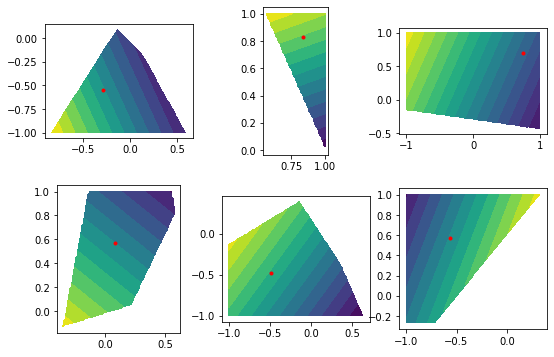

In [32]:
plt.figure(figsize=(9, 6))

for k in range(6):
    plt.subplot(2, 3, k+1)
    ax = plt.gca()
    ax.set_aspect('equal')
    A,b,x,c = generateLP()
    x0 = findStrictlyFeasibleSolution(A,b)
    plotLP(A,b,c)
    plt.plot(x0[0],x0[1],marker='.',color='red')
plt.show()

On peut finalement écrire une fonction qui résout un programme linéaire sans avoir besoin de point de départ :

In [14]:
def LinearSolver(A,b,c,record_history=False):
    x0 = findStrictlyFeasibleSolution(A,b)
    if x0 is not None:
        (x,dual),history = LPBarrierMethod(A,b,c,x0,record_history=True)
        if record_history:
            return (x,dual),history
        else:
            return x,dual
    else:
        return None

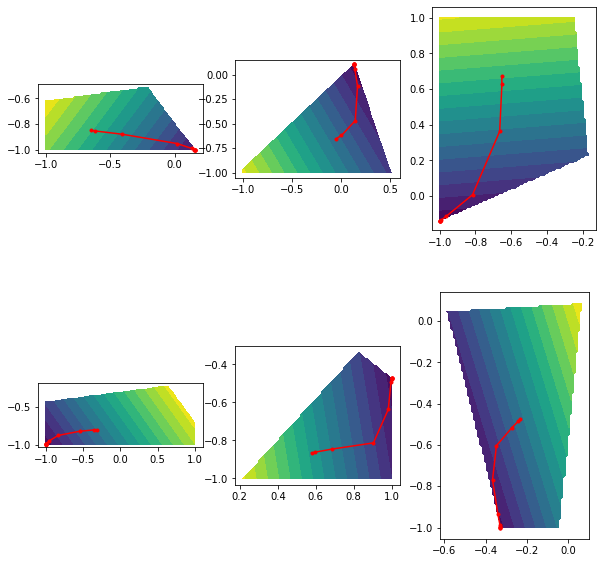

In [15]:
nb = 6
plt.figure(figsize=(10, 5*(nb/3)))
for k in range(nb):
    plt.subplot(2, 3, k+1)
    ax = plt.gca()
    ax.set_aspect('equal')
    A,b,_,c = generateLP()
    _,history = LinearSolver(A,b,c,record_history=True)
    plotLP(A,b,c)
    plt.plot(history[1:,0],history[1:,1],marker='.',color='red')
plt.show()

Finalement, on peut comparer nos résultats avec ceux du solveur CVX :

> Note : j'utilise la librairie cvxopt de python, on peut l'installer avec :
>
>     pip install cvxopt
>
> ou avec conda :
> 
>     conda install -c conda-forge cvxopt

In [16]:
from cvxopt import matrix, solvers
import time

In [17]:
def compareCVX(n,k):
    values = []
    times = []
    solvers.options['show_progress'] = False
    for k in range(n):
        A,b,_,c = generateLP(k)
        A2,b2,c2 = matrix(A),matrix(b),matrix(c)
        
        t3 = time.perf_counter()
        primal_2 = solvers.lp(c2,A2,b2)['x']
        t4 = time.perf_counter()
        
        t1 = time.perf_counter()
        primal_1 = LinearSolver(A,b,c)
        t2 = time.perf_counter()
        time1 = t1-t2
        
        time2 = t3-t4
        
        if primal_1 is not None:
            opt1 = np.dot(c,primal_1[0]).item()
            opt2 = np.dot(c,primal_2).item()
            values.append((opt1-opt2)/opt2)
        else:
            values.append(None)
        times.append(time1/time2)
    return values, times, np.mean(values), np.mean(times)

def plotCompare(n,k=5):
    values, times, avgv, avgt = compareCVX(n,k)
    x = np.arange(len(values))
    plt.figure(figsize=(10, 5))
    
    plt.subplot(1, 2, 1, title='Optimum difference %')
    plt.plot(x,values)
    
    plt.subplot(1, 2, 2, title='Times difference %')
    plt.plot(x,times)
    
    print("Average Optimal Value Difference % : {:.2f}%, Average Time Difference % : {:.2f}%".format(avgv,avgt))
    plt.show()

Average Optimal Value Difference % : -0.00%, Average Time Difference % : 5.99%


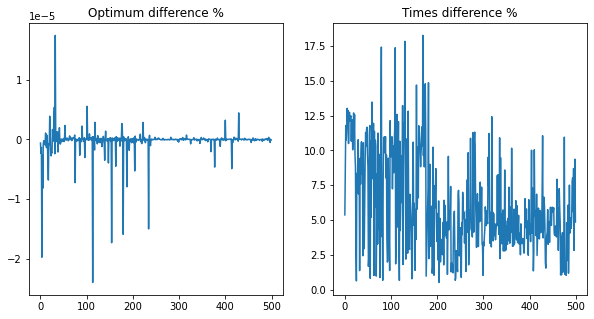

In [37]:
plotCompare(500)

En moyenne mon solveur est donc autant précis le solveur CVX. Il est par contre beaucoup plus lent (en moyenne 6 fois plus lent !) qui peut s'expliquer par le fait que les méthodes que j'ai implémentées sont très peu optimisées, par exemple pour calculer les pas de Newton, je résous directement un système linéaire plutôt que de faire des factorisations de Cholesky et autres.